# Step 2. Clean up the data and arrange it for analysis

In [1]:
import numpy as np
import pandas as pd
import datetime

from datascience import *
from datetime import timedelta
from datetime import date
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import locale

In [2]:
# Helpers Functions

def print_stats(data): 
    '''Prints common stats for a data array'''
    
    data_mean = np.mean(data)
    data_std = np.std(data)
    data_min = min(data)
    data_max = max(data)

    percent_5 = percentile(5, data)
    percent_95 = percentile(95, data)
    percent_1 = percentile(1, data)
    percent_99 = percentile(99, data)
    
    percent_25 = percentile(25, data)
    percent_50 = percentile(50, data)
    percent_75 = percentile(75, data)

    print("Avg:", data_mean, "\tStd:", data_std, "\tMin:", data_min, "\tMax:", data_max)
    print(" 5%:", percent_5, "\t95%:", percent_95)
    print(" 1%:", percent_1, "\t99%:", percent_99)
    print("25%:", percent_25, "\t50%:", percent_50, '\t75%', percent_75)
    

def print_col_stats(table, col_name):
    ''' Print the stats For column named'''
    
    print(col_name + "Stats")
    data = table.column(col_name)
    print_stats(data)
    
def draw_hist(table : Table, col_name, offset_percent=0):
    ''' Draw a histogram for table with an additional offset percent'''
    data = table.column(col_name)
    offset_start = percentile(offset_percent, data)
    offset_end = percentile(100-offset_percent, data)
    table.hist(col_name, bins=np.arange(offset_start, offset_end, (offset_end-offset_start)/20))
               
def col_stats(table, col_name):
    ''' Prints state for a column in table'''
    print_col_stats(table, col_name)
    draw_hist(table, col_name)
               

   

In [3]:
# helpers

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

In [4]:
# Import CSV
csv_directory = "data/csv/"

all_sales_data = Table.read_table(csv_directory+'manhattan.csv', low_memory=False)


In [5]:
# remove and sales less than $10,000 they are likely to be a property transfer rather than an actual sale

all_sales_data = all_sales_data.where('SALE PRICE', are.above(10000))

In [6]:
# Declare column names to allow for auto completion :)

COL_SALE_DATE = 'SALE DATE'

COL_FIRST_SALE_DATE = 'FIRST SALE'
COL_LAST_SALE_DATE = 'LAST SALE'
COL_FIRST_SALE_PRICE = 'FIRST PRICE'
COL_LAST_SALE_PRICE = 'LAST PRICE'
COL_FULL_ADDRESS = 'FULL ADDRESS'
COL_PRICE_CHANGE = 'PRICE CHANGE'
COL_PERIOD = 'PERIOD'

COL_SALE_YEAR = 'SALE_YEAR'
COL_SALE_MONTH = 'SALE_MONTH'
COL_SALE_PRICE = 'SALE PRICE'

In [7]:
# Convert sale date from a string to datetime type

dates = [ datetime.strptime(d, '%Y-%m-%d') for d in all_sales_data.column(COL_SALE_DATE) ]

# Drop string sale date column
all_sales_data = all_sales_data.drop(COL_SALE_DATE)
# Add the sales as type datetime
all_sales_data = all_sales_data.with_column(COL_SALE_DATE, dates)
# Move sale date to the first column
all_sales_data = all_sales_data.move_to_start(COL_SALE_DATE)


In [8]:
# SPOT CHECK: Understand the data lables we might be interested in

all_sales_data.sort("SALE PRICE").show(10)
all_sales_data.labels

SALE DATE,Unnamed: 0,ADDRESS,APARTMENT NUMBER,BLOCK,BOROUGH,BUILDING CLASS AS OF FINAL ROLL 17/18,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,EASE-MENT,GROSS SQUARE FEET,LAND SQUARE FEET,LOT,NEIGHBORHOOD,RESIDENTIAL UNITS,SALE PRICE,TAX CLASS AS OF FINAL ROLL 17/18,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE
2004-06-02 00:00:00,13333,870 7 AVENUE,1614,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1322,MIDTOWN WEST,0,10007,nan,4,4,1,0,10019
2004-06-18 00:00:00,13428,870 7 AVENUE,1511,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1338,MIDTOWN WEST,0,10007,nan,4,4,1,0,10019
2003-04-21 00:00:00,19770,220,104,1171,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1917,UPPER WEST SIDE (59-79),0,10020,nan,4,4,1,0,10069
2011-06-09 00:00:00,11902,200 WEST 56TH STREET,,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1199,MIDTOWN WEST,0,10035,nan,4,4,1,0,10019
2011-03-03 00:00:00,11956,200 WEST 56TH STREET,,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1208,MIDTOWN WEST,0,10035,nan,4,4,1,0,10019
2011-12-21 00:00:00,12903,870 7 AVENUE,220,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1721,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-10-19 00:00:00,12904,870 7 AVENUE,220,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1721,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-08-24 00:00:00,12908,870 7 AVENUE,220,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1721,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-02-23 00:00:00,12922,870 7 AVENUE,221,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1722,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019
2011-09-14 00:00:00,12940,870 7 AVENUE,223,1027,1,nan,R5,R5,28 COMMERCIAL CONDOS,1,,0,0,1724,MIDTOWN WEST,0,10035,nan,4,4,1,1925,10019


('SALE DATE',
 'Unnamed: 0',
 'ADDRESS',
 'APARTMENT NUMBER',
 'BLOCK',
 'BOROUGH',
 'BUILDING CLASS AS OF FINAL ROLL 17/18',
 'BUILDING CLASS AT PRESENT',
 'BUILDING CLASS AT TIME OF SALE',
 'BUILDING CLASS CATEGORY',
 'COMMERCIAL UNITS',
 'EASE-MENT',
 'GROSS SQUARE FEET',
 'LAND SQUARE FEET',
 'LOT',
 'NEIGHBORHOOD',
 'RESIDENTIAL UNITS',
 'SALE PRICE',
 'TAX CLASS AS OF FINAL ROLL 17/18',
 'TAX CLASS AT PRESENT',
 'TAX CLASS AT TIME OF SALE',
 'TOTAL UNITS',
 'YEAR BUILT',
 'ZIP CODE')

In [9]:
# Remove columns we don't actually need. e.g. lot, block etc

all_sales_data = all_sales_data.select(['SALE DATE', 'SALE PRICE', 'ADDRESS','APARTMENT NUMBER', 'YEAR BUILT', 'NEIGHBORHOOD', 'ZIP CODE', 'BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY'])

In [10]:
# Combine the Address and Apt No. The data here seems a little messy. Sometime the address itself contains the apt no,
# other times it's seperated. Let's create a full address column that combines them into a single address

def combine_address(address, aptNo):
    """Combine the address and Apartment into a single result"""
    temp = address.strip()
    if len(aptNo.strip()) > 0:
        temp = temp + ', ' + aptNo.strip()
    return temp

full_address = all_sales_data.apply(combine_address, ['ADDRESS', 'APARTMENT NUMBER'])

# Add a Full Address column
all_sales_data =  all_sales_data.with_column(COL_FULL_ADDRESS, full_address)

/Users/somya/Library/Python/3.7/lib/python/site-packages/datascience/tables.py:361: FutureWarning: column lists are deprecated; pass each as an argument
  "column lists are deprecated; pass each as an argument", FutureWarning)


In [11]:
# Try to understand Building Class Codes. What are the most common Codes?

all_sales_data.group(['BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']).sort('count', descending=True).show(20)

# Ok mostly condos and co-ops as expected

# Question what's R5 -  COMMERCIAL CONDOS? ignoring for now

BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,count
R4,13 CONDOS - ELEVATOR APARTMENTS,90128
D4,10 COOPS - ELEVATOR APARTMENTS,83556
R5,28 COMMERCIAL CONDOS,15569
R4,13 CONDOS - ELEVATOR APARTMENTS,10856
C6,09 COOPS - WALKUP APARTMENTS,10413
D4,10 COOPS - ELEVATOR APARTMENTS,10325
R9,17 CONDOPS,10097
H2,25 LUXURY HOTELS,6204
R9,17 CONDO COOPS,4148
RH,45 CONDO HOTELS,4011


Let's pick out the condos for now. 
Reference Data: [NYC Building Codes](https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html) 

In [12]:

condos = all_sales_data.where('BUILDING CLASS AT TIME OF SALE', are.contained_in("R1R2R3R4R6"))

# Spot Check condo data
condos.sample(10)

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2012-11-29 00:00:00,1776000,343 EAST 30TH STREET,19-C,1962,KIPS BAY,10016,R4,13 CONDOS - ELEVATOR APARTMENTS,"343 EAST 30TH STREET, 19-C"
2015-07-14 00:00:00,1205000,225 EAST 34TH STREET,3K,0,MURRAY HILL,10016,R4,13 CONDOS - ELEVATOR APARTMENTS,"225 EAST 34TH STREET, 3K"
2008-10-27 00:00:00,988788,200 EAST 66TH STREET,A1506,1951,UPPER EAST SIDE (59-79),10065,R4,13 CONDOS - ELEVATOR APARTMENTS,"200 EAST 66TH STREET, A1506"
2015-12-08 00:00:00,451230,156-08 RIVERSIDE DRIVE WEST,5K,1920,WASHINGTON HEIGHTS LOWER,10032,R4,13 CONDOS - ELEVATOR APARTMENTS,"156-08 RIVERSIDE DRIVE WEST, 5K"
2015-11-03 00:00:00,1445915,175 WEST 95TH STREET,17G,1971,UPPER WEST SIDE (79-96),10025,R4,13 CONDOS - ELEVATOR APARTMENTS,"175 WEST 95TH STREET, 17G"
2011-11-02 00:00:00,1372410,38 DELANCEY STREET,12D,2005,LOWER EAST SIDE,10002,R4,13 CONDOS - ELEVATOR APARTMENTS,"38 DELANCEY STREET, 12D"
2011-05-24 00:00:00,677136,123 3 AVENUE,4B,2009,EAST VILLAGE,10003,R4,13 CONDOS - ELEVATOR APARTMENTS,"123 3 AVENUE, 4B"
2014-08-25 00:00:00,1735000,121 EAST 23RD STREET,6D,2004,GRAMERCY,10010,R4,13 CONDOS - ELEVATOR APARTMENTS,"121 EAST 23RD STREET, 6D"
2017-12-29 00:00:00,925000,235 EAST 40TH STREET,3D,1986,MIDTOWN EAST,10016,R4,13 CONDOS - ELEVATOR APARTMENTS,"235 EAST 40TH STREET, 3D"
2017-01-31 00:00:00,2050000,15 BROAD STREET,1916,1914,FINANCIAL,10005,R4,13 CONDOS - ELEVATOR APARTMENTS,"15 BROAD STREET, 1916"


Let's find condos with multiple sales

In [13]:
condos.group(COL_FULL_ADDRESS).sort(1, descending=True)

FULL ADDRESS,count
1 WEST END AVENUE,136
45 EAST 22ND STREET,51
245 WEST 99TH STREET,50
171 WEST 131 STREET,44
959 1 AVENUE,42
416 WEST 52ND STREET,39
245 WEST 99TH STREET,37
2094 FREDRICK DOUGLASS BL,35
172 MADISON AVENUE,35
360 EAST 89TH STREET,23


It looks like apt numbers are missing for most of the top sales. In order to focus on manhattan apartments let's ignore anything without an apt number. i.e. anything without a ',' (comma) in the Full Address

In [14]:

multi_sale_condos = condos.where('FULL ADDRESS', are.containing(',')).group('FULL ADDRESS').sort(1, descending=True).where('count', are.above(1))
multi_sale_condos



FULL ADDRESS,count
"2 EAST 55 STREET, 835",8
"2 EAST 55TH STREET, 935",7
"2 EAST 55 STREET, 921",7
"2 EAST 55 STREET, 936",6
"2 EAST 55 STREET, 903",6
"1420 YORK AVENUE, 5M",6
"140 7 AVENUE, 6A",6
"900 PARK AVENUE, 8E",5
"900 PARK AVENUE, 27E",5
"90 WILLIAM STREET, 2A",5


There are a lot less records with apt numbers, but still roughly 16K records enough to proceed.

In [15]:
# Define a new table for condos with multiple sales. 

multi_sale_condos = multi_sale_condos.join(COL_FULL_ADDRESS, condos)
multi_sale_condos.sort(0)

FULL ADDRESS,count,SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
"1 BOND STREET, 2B",2,2004-08-04 00:00:00,31000,1 BOND STREET,2B,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2B",2,2009-08-20 00:00:00,1591000,1 BOND STREET,2B,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2C",2,2017-08-18 00:00:00,5640000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2C",2,2010-12-15 00:00:00,600000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2009-04-24 00:00:00,1195000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2014-01-07 00:00:00,1925000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2013-06-14 00:00:00,7200000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2008-06-06 00:00:00,5030000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2006-08-30 00:00:00,1565000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2013-08-20 00:00:00,2415000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS


## Find the first and last sale date for each condo

In [16]:
first_sale_dates = multi_sale_condos.select(0, 2).group([0], min)
last_sale_dates = multi_sale_condos.select(0, 2).group([0], max)

# Spot check data
first_sale_dates.show(5)
last_sale_dates.show(5)

FULL ADDRESS,SALE DATE min
"1 BOND STREET, 2B",2004-08-04 00:00:00
"1 BOND STREET, 2C",2010-12-15 00:00:00
"1 BOND STREET, 2D",2009-04-24 00:00:00
"1 BOND STREET, 3A",2008-06-06 00:00:00
"1 BOND STREET, 4D",2006-08-30 00:00:00


FULL ADDRESS,SALE DATE max
"1 BOND STREET, 2B",2009-08-20 00:00:00
"1 BOND STREET, 2C",2017-08-18 00:00:00
"1 BOND STREET, 2D",2014-01-07 00:00:00
"1 BOND STREET, 3A",2013-06-14 00:00:00
"1 BOND STREET, 4D",2013-08-20 00:00:00


In [17]:
# Update Labels

first_sale_dates = first_sale_dates.relabel(1, COL_FIRST_SALE_DATE)
last_sale_dates = last_sale_dates.relabel(1, COL_LAST_SALE_DATE)

In [18]:
# Join with Condos to get the sale price
first_sale_dates = first_sale_dates.join(COL_FULL_ADDRESS, condos, 'FULL ADDRESS').where('SALE DATE', are.equal_to, 'FIRST SALE')
first_sale_dates = first_sale_dates.select(COL_FULL_ADDRESS, 'FIRST SALE', 'SALE PRICE')


last_sale_dates = last_sale_dates.join(COL_FULL_ADDRESS, condos, 'FULL ADDRESS').where('SALE DATE', are.equal_to, 'LAST SALE')
last_sale_dates = last_sale_dates.select(COL_FULL_ADDRESS, 'LAST SALE', 'SALE PRICE')

In [19]:
first_sale_dates.show(5)
last_sale_dates.show(5)

# Hmm earlier we had 16187 now we have more! Could we have multiple sale records for the same date??

FULL ADDRESS,FIRST SALE,SALE PRICE
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000


FULL ADDRESS,LAST SALE,SALE PRICE
"1 BOND STREET, 2B",2009-08-20 00:00:00,1591000
"1 BOND STREET, 2C",2017-08-18 00:00:00,5640000
"1 BOND STREET, 2D",2014-01-07 00:00:00,1925000
"1 BOND STREET, 3A",2013-06-14 00:00:00,7200000
"1 BOND STREET, 4D",2013-08-20 00:00:00,2415000


In [40]:
# Yep duplicate sales on the same day wtf!

first_sale_dates.groups([0,1]).sort(2, descending=True).where(2, are.above(1))

FULL ADDRESS,FIRST SALE,count
"ONE WALL STREET COURT, 807",2006-11-14 00:00:00,1
"993 LEXINGTON AVENUE, 3S",2013-10-30 00:00:00,1
"99 READE STREET, 5W",2011-04-11 00:00:00,1
"99 READE STREET, 5F",2006-04-03 00:00:00,1
"99 READE STREET, 3W",2003-11-03 00:00:00,1
"99 READE STREET, 3F",2007-02-07 00:00:00,1
"99 JOHN STREET, PH10",2012-04-24 00:00:00,1
"99 JOHN STREET, PH04",2011-02-18 00:00:00,1
"99 JOHN STREET, PH03",2011-04-20 00:00:00,1
"99 JOHN STREET, 926",2010-06-11 00:00:00,1


In [21]:
# Spot check some duplicate addresses to understand what's going on
condos.where('FULL ADDRESS', are.equal_to('2 EAST 55 STREET, 921')).show()
first_sale_dates.where('FULL ADDRESS', are.containing('201 WEST 17TH'))

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2006-10-09 00:00:00,467251,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-10-09 00:00:00,403977,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-09-05 00:00:00,451230,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,486720,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,496860,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,486922,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22 00:00:00,412393,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"


FULL ADDRESS,FIRST SALE,SALE PRICE


In [22]:
# It's not really clear what might be going on. Let's just take the corresponding min and max value to keep moving along

first_sale_dates = first_sale_dates.group([0,1], min)
last_sale_dates = last_sale_dates.group([0,1], max)

In [23]:
# Relabel and join the first and last sale tables to create a new condo sales table

first_sale_dates = first_sale_dates.relabel(2, COL_FIRST_SALE_PRICE)
last_sale_dates = last_sale_dates.relabel(2, COL_LAST_SALE_PRICE)


condo_sales = first_sale_dates.join(COL_FULL_ADDRESS, last_sale_dates, COL_FULL_ADDRESS)
condo_sales

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000,2009-08-20 00:00:00,1591000
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000,2017-08-18 00:00:00,5640000
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000,2014-01-07 00:00:00,1925000
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000,2013-06-14 00:00:00,7200000
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000,2013-08-20 00:00:00,2415000
"1 BOND STREET, 6A",2012-12-12 00:00:00,3600000,2017-09-06 00:00:00,5250000
"1 BOND STREET, 6B",2004-12-01 00:00:00,2996000,2016-05-20 00:00:00,4350000
"1 CENTRAL PARK SOUTH, 2002",2010-12-01 00:00:00,4600000,2018-06-22 00:00:00,4750000
"1 CENTRAL PARK SOUTH, 503",2012-12-18 00:00:00,7995000,2017-02-24 00:00:00,10150000
"1 CENTRAL PARK WEST, 23B",2008-04-03 00:00:00,5580000,2012-06-28 00:00:00,6200000


In [24]:
# Calculate Price and date Diffs

price_diffs = condo_sales.column('LAST PRICE') - condo_sales.column('FIRST PRICE')
date_diffs = condo_sales.column('LAST SALE') - condo_sales.column('FIRST SALE')

date_diffs = [ d.days for d in date_diffs ]


condo_sales = condo_sales.with_column( COL_PRICE_CHANGE, price_diffs, COL_PERIOD, date_diffs)
condo_sales.set_format(COL_PRICE_CHANGE, NumberFormatter())

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"1 BOND STREET, 2B",2004-08-04 00:00:00,31000,2009-08-20 00:00:00,1591000,"1,560,000",1842
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000,2017-08-18 00:00:00,5640000,"5,040,000",2438
"1 BOND STREET, 2D",2009-04-24 00:00:00,1195000,2014-01-07 00:00:00,1925000,"730,000",1719
"1 BOND STREET, 3A",2008-06-06 00:00:00,5030000,2013-06-14 00:00:00,7200000,"2,170,000",1834
"1 BOND STREET, 4D",2006-08-30 00:00:00,1565000,2013-08-20 00:00:00,2415000,"850,000",2547
"1 BOND STREET, 6A",2012-12-12 00:00:00,3600000,2017-09-06 00:00:00,5250000,"1,650,000",1729
"1 BOND STREET, 6B",2004-12-01 00:00:00,2996000,2016-05-20 00:00:00,4350000,"1,354,000",4188
"1 CENTRAL PARK SOUTH, 2002",2010-12-01 00:00:00,4600000,2018-06-22 00:00:00,4750000,"150,000",2760
"1 CENTRAL PARK SOUTH, 503",2012-12-18 00:00:00,7995000,2017-02-24 00:00:00,10150000,"2,155,000",1529
"1 CENTRAL PARK WEST, 23B",2008-04-03 00:00:00,5580000,2012-06-28 00:00:00,6200000,"620,000",1547


PRICE CHANGEStats
Avg: 385685.6324828566 	Std: 2520627.5306744017 	Min: -183014844 	Max: 44312249
 5%: -157712 	95%: 1850000
 1%: -1424528 	99%: 5079780
25%: 54540 	50%: 235000 	75% 547500


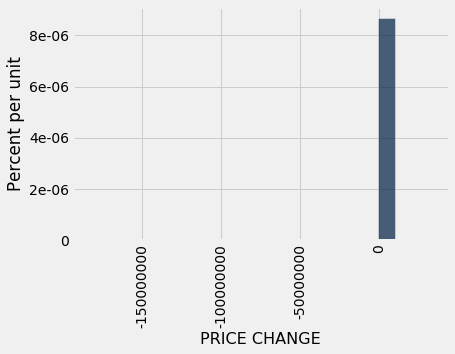

In [25]:
# Understand price difference data
col_stats(condo_sales, COL_PRICE_CHANGE)


There look to be some signifiant outliers here. The 99 percentile is $5 but the max is $44 MM a significant. The min value is -$$183MM, a $183 million dollor loss! 

Let's remove outliers so they dont imapact pricing analysis, but we definitely need to come back and look into what happened here. 

PRICE CHANGEStats
Avg: 420234.0630988401 	Std: 670605.5475993928 	Min: -1424528 	Max: 5069645
 5%: -119748 	95%: 1669925
 1%: -581575 	99%: 3433275
25%: 58040 	50%: 234975 	75% 535000


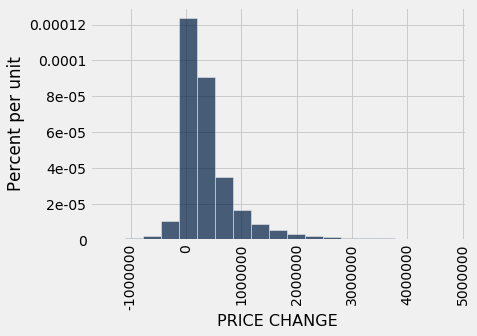

In [26]:
# strip out the Price chnage outliers . 
percent_1 = percentile(1, price_diffs)
percent_99 = percentile(99, price_diffs)

condo_sales = condo_sales.where(COL_PRICE_CHANGE, are.between(percent_1, percent_99))
col_stats(condo_sales, COL_PRICE_CHANGE)

The data looks a look cleaner now to work with

In [27]:
# Some sales are on recorded twice for the same date!


condo_sales.where( COL_FIRST_SALE_DATE, are.equal_to, COL_LAST_SALE_DATE )



FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"1 IRVING PLACE, G27B",2017-12-14 00:00:00,1950000,2017-12-14 00:00:00,1950000,0,0
"1 IRVING PLACE, G9B",2017-12-14 00:00:00,1362500,2017-12-14 00:00:00,1362500,0,0
"1 MOUNT MORRIS PARK WE, 1C",2017-09-26 00:00:00,1227000,2017-09-26 00:00:00,1227000,0,0
"1 RIVER TERRACE, 4S",2017-12-06 00:00:00,2790000,2017-12-06 00:00:00,2790000,0,0
"1 WALL STREET COURT, 201",2017-09-13 00:00:00,1160000,2017-09-13 00:00:00,1160000,0,0
"10 LITTLE WEST STREET, 24E",2017-11-14 00:00:00,2700000,2017-11-14 00:00:00,2700000,0,0
"10 MADISON SQUARE WEST, 4F",2017-12-18 00:00:00,6950000,2017-12-18 00:00:00,6950000,0,0
"100 11TH AVENUE, 12B",2017-12-15 00:00:00,4300000,2017-12-15 00:00:00,4300000,0,0
"100 CENTRAL PARK SOUTH, 4B",2017-11-14 00:00:00,2350000,2017-11-14 00:00:00,2350000,0,0
"100 CENTRAL PARK SOUTH, 6A",2017-12-14 00:00:00,2025000,2017-12-14 00:00:00,2025000,0,0


In [28]:
# Let's spot check these

all_sales_data.where(COL_FULL_ADDRESS, are.equal_to('101 LEONARD STREET, 3D')).sort(0)

# Hmm something strange going no. Let's ignore for now

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2016-02-05 00:00:00,2925000,101 LEONARD STREET,3D,1920,CHINATOWN,10013,R4,13 CONDOS - ELEVATOR APARTMENTS,"101 LEONARD STREET, 3D"
2016-02-05 00:00:00,1812000,101 LEONARD STREET,3D,1920,CHINATOWN,10013,R4,13 CONDOS - ELEVATOR APARTMENTS,"101 LEONARD STREET, 3D"


In [29]:
# Ignore multiple sales on same date

condo_sales = condo_sales.where( COL_FIRST_SALE_DATE, are.not_equal_to, COL_LAST_SALE_DATE )




## Issues with time between sales

Looking into the time between 2 sales for the same apartment we find some unusal data

In [30]:
condo_sales.sort(COL_PERIOD)

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"2 EAST 55TH ST, 835",2006-08-15 00:00:00,554946,2006-08-16 00:00:00,486720,"-68,226",1
"212 EAST 70TH STREET, 2D",2017-03-23 00:00:00,312500,2017-03-24 00:00:00,725000,"412,500",1
"95 CHARLES STREET, 5",2016-03-25 00:00:00,850000,2016-03-26 00:00:00,850000,0,1
"203-05 WEST 112 STREET, 1W",2003-12-17 00:00:00,967338,2003-12-19 00:00:00,967338,0,2
"238 EAST 47 STREET, 22D",2004-07-14 00:00:00,105000,2004-07-16 00:00:00,1100000,"995,000",2
"227 EAST 111 STREET, 5B",2005-03-28 00:00:00,540881,2005-03-31 00:00:00,995000,"454,119",3
"879-87 8 AVENUE, 2J",2003-11-13 00:00:00,620000,2003-11-16 00:00:00,620000,0,3
"157 WEST 111 STREET, 4E",2007-03-09 00:00:00,776925,2007-03-13 00:00:00,834965,"58,040",4
"500 WEST 43RD STREET, 24F",2014-01-03 00:00:00,800350,2014-01-07 00:00:00,800350,0,4
"10 EAST 14TH ST, 2",2007-01-04 00:00:00,1483300,2007-01-09 00:00:00,2698362,"1,215,062",5


Still Looks like there is some strange data where the sale dates are a few days apart, for most regular sale cycles we expect a gap of atleast 60-90 days. 
Let's ignore anything less that 3 months apart i.e. 90 days. 


In [31]:
condo_sales = condo_sales.where( COL_PERIOD, are.above(90) )

PERIODStats
Avg: 2046.175500103114 	Std: 1203.5303794386243 	Min: 91 	Max: 5688
 5%: 314 	95%: 4194
 1%: 136 	99%: 4964
25%: 1057 	50%: 1918 	75% 2896


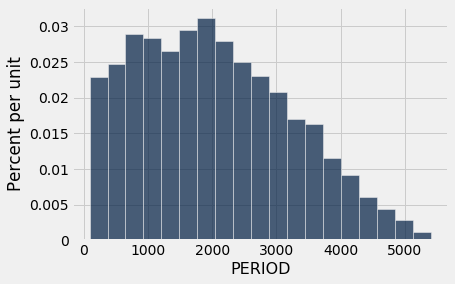

In [32]:
# Understaing the distribution of time between sales

col_stats(condo_sales, COL_PERIOD)


In [33]:
# Let's try to see if there is anything strange gonig going on with large price chnages

condo_sales.sort(COL_PRICE_CHANGE, descending=True)



FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"25 COLUMBUS CIRCLE, ST57D",2003-12-26 00:00:00,4130355,2016-09-01 00:00:00,9200000,"5,069,645",4633
"15 CENTRAL PARK WEST, 12L",2007-12-06 00:00:00,4439570,2014-08-01 00:00:00,9500000,"5,060,430",2430
"25 COLUMBUS CIRCLE, ST68E",2004-03-12 00:00:00,2448769,2015-12-15 00:00:00,7500000,"5,051,231",4295
"1 BOND STREET, 2C",2010-12-15 00:00:00,600000,2017-08-18 00:00:00,5640000,"5,040,000",2438
"95 CHARLES STREET, 3",2012-09-11 00:00:00,915180,2013-10-15 00:00:00,5950000,"5,034,820",399
"80 COLUMBUS CIRCLE, NT69A",2004-02-27 00:00:00,3920263,2016-10-24 00:00:00,8950000,"5,029,737",4623
"15 CENTRAL PARK WEST, 6E",2007-11-12 00:00:00,5243987,2015-09-03 00:00:00,10200000,"4,956,013",2852
"99 JANE STREET, 10B",2004-11-17 00:00:00,2950000,2014-08-12 00:00:00,7900000,"4,950,000",3555
"432 PARK AVENUE, 53A",2016-03-01 00:00:00,6006511,2018-05-02 00:00:00,10950000,"4,943,489",792
"15 CENTRAL PARK WEST, 36B",2008-04-28 00:00:00,7473955,2008-09-03 00:00:00,12400000,"4,926,045",128


## Average Daily Price Change

Let's calulate the average daily price change to spot any other odd data. 

In [34]:
daily_change = condo_sales.column(COL_PRICE_CHANGE) / condo_sales.column(COL_PERIOD) 

# Daily price change column name
COL_DAILY_PRICE_CHANGE = 'DAILY PRICE CHANGE'

condo_sales = condo_sales.with_column(COL_DAILY_PRICE_CHANGE , daily_change ).sort(COL_DAILY_PRICE_CHANGE, descending=True)
condo_sales


FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD,DAILY PRICE CHANGE
"15 CENTRAL PARK WEST, 36B",2008-04-28 00:00:00,7473955,2008-09-03 00:00:00,12400000,"4,926,045",128,38484.7
"56 LEONARD STREET, PH55",2017-03-02 00:00:00,21814384,2017-08-04 00:00:00,26500000,"4,685,616",155,30229.8
"151 EAST 58 STREET, PH55E",2005-08-16 00:00:00,9622462,2005-12-15 00:00:00,13000000,"3,377,538",121,27913.5
"157 WEST 57TH STREET, 58A",2014-05-01 00:00:00,30551000,2014-10-02 00:00:00,34000000,"3,449,000",154,22396.1
"201 EAST 80TH STREET, 9A",2016-08-19 00:00:00,657401,2016-12-07 00:00:00,2995000,"2,337,599",110,21250.9
"19 BEACH STREET, 6",2018-02-28 00:00:00,2410796,2018-07-31 00:00:00,5500000,"3,089,204",153,20190.9
"250 WEST STREET, 7A",2013-03-18 00:00:00,6379336,2013-06-24 00:00:00,8200000,"1,820,664",98,18578.2
"212 WEST 18TH STREET, 18C",2014-12-23 00:00:00,5718750,2015-09-10 00:00:00,10414000,"4,695,250",261,17989.5
"554 BROOME ST, R6",2006-03-30 00:00:00,380250,2006-08-16 00:00:00,2850000,"2,469,750",139,17768
"101 WEST 87TH STREET, PH",2014-07-01 00:00:00,7764156,2014-11-05 00:00:00,10000000,"2,235,844",127,17605.1


DAILY PRICE CHANGEStats
Avg: 345.57870328916573 	Std: 1006.5882882351979 	Min: -13128.990566037735 	Max: 38484.7265625
 5%: -94.5934693877551 	95%: 1315.7894736842106
 1%: -576.700557103064 	99%: 3543.111455108359
25%: 50.51221849544801 	50%: 149.44649446494466 	75% 363.8253638253638


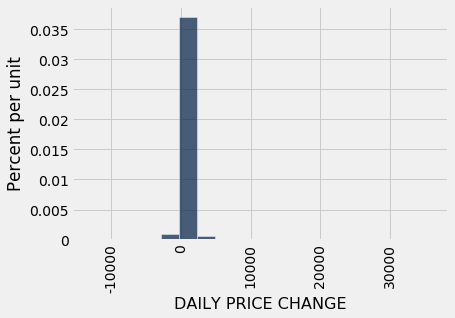

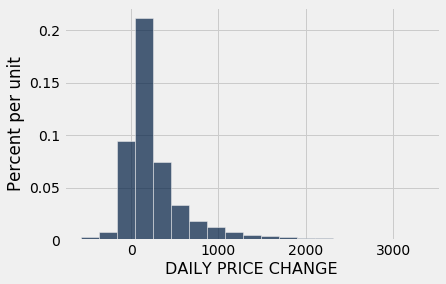

In [35]:
col_stats(condo_sales, COL_DAILY_PRICE_CHANGE)
draw_hist(condo_sales, COL_DAILY_PRICE_CHANGE, 1)

## Looks like there are some significant outliers but most of the data  1%

My suspicion is that properties with a high daily price change were underpriced for the first sale and then corrected later. Again I'd love to discover these ahead of time, but let's ignore the outliers for now. 

In [36]:
# strip out the Dailys Price change outliers. 

price_change_diffs = condo_sales.column(COL_DAILY_PRICE_CHANGE)

percent_1 = percentile(1, price_change_diffs)
percent_99 = percentile(99, price_change_diffs)

condo_sales = condo_sales.where(COL_DAILY_PRICE_CHANGE, are.between(percent_1, percent_99))


# Save the Condo data


In [41]:
# save to csv
condos.to_csv(csv_directory+"condos.csv")

condo_sales.to_csv(csv_directory+"condo_sales.csv")